<a href="https://colab.research.google.com/github/marcus-wuertz/Analytics-Code/blob/main/DS4220_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\color{purple}{\text{Question 1}}$

In [ ]:
bc_data <- read.csv('/content/sample_data/breast cancer.csv')

In [ ]:
#install.packages('dplyr')
#install.packages(c('fastDummies', 'janitor','magrittr'))
library(dplyr)
library(fastDummies)
library(janitor)
library(magrittr)

# convert target variable to be a factor
bc_data$diagnosis <- as.factor(bc_data$diagnosis)

# Remove the dependent variable 'diagnosis' from bc_data
bc_data_2 <- bc_data %>%
  dplyr::select(-diagnosis)

# Ensuring variables have no spaces, replacing with underscores
bc_data_3 <- bc_data_2 %>%
  clean_names()

In [ ]:
#install.packages('caret')
library(caret)

# Get index of variables with near-zero variance
nearZero_index <- bc_data_3 %>%
  nearZeroVar()

# Remove variables with near zero variance
bc_data_4 <- bc_data_3[, nearZero_index] %>%
  scale() %>%
  as.data.frame() %>%
  cbind(diagnosis = bc_data$diagnosis)

# Split data to get training data and testing data
set.seed(35)

# Training data is 80% of original data and testing data is 20%.
index <- sample(x = nrow(bc_data_4), size = nrow(bc_data_4) * 0.8, replace = FALSE)
training_data <- as.data.frame(bc_data_4[index, ])
testing_data <- as.data.frame(bc_data_4[index, ])

In [ ]:
#install.packages("MASS")
#install.packages("mlr")
library("MASS")
library("mlr")

# Defining the data
train <- makeClassifTask(data = bc_data, target = "diagnosis")
test <- makeClassifTask(data = bc_data, target = "diagnosis")

In [ ]:
# Define algorithms to train the models
dt_algo <- makeLearner(cl = "classif.rpart", predict.type = "prob")
nb_algo <- makeLearner(cl = "classif.naiveBayes", predict.type = 'prob')
lda_algo <- makeLearner(cl = "classif.lda", predict.type = 'prob')
lr_algo <- makeLearner(cl = "classif.logreg", predict.type = 'prob')

# Training the models
dt_model <- mlr::train(learner = dt_algo, task = train)
nb_model <- mlr::train(learner = nb_algo, task = train)
lda_model <- mlr::train(learner = lda_algo, task = train)
lr_model <- mlr::train(learner = lr_algo, task = train)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [ ]:
# Testing data and getting predictions
dt_pred <- predict(dt_model, task = test)
nb_pred <- predict(nb_model, task = test)
lda_pred <- predict(lda_model, task = test)
lr_pred <- predict(lr_model, task = test)

# Get class label for the predictions
dt_label <- as.data.frame(dt_pred$data$response) %>% setNames("Prediction")
nb_label <- as.data.frame(nb_pred$data$response) %>% setNames("Prediction")
lda_label <- as.data.frame(lda_pred$data$response) %>% setNames("Prediction")
lr_label <- as.data.frame(lr_pred$data$response) %>% setNames("Prediction")

# Combine data for comparison
comparison_data <- cbind(dt_label, nb_label, lda_label, lr_label) %>%
  setNames(c("DT", "NB", "LDA", "LR"))
head(comparison_data)

,DT,NB,LDA,LR
,<fct>,<fct>,<fct>,<fct>
1,M,M,M,M
2,M,M,M,M
3,M,M,M,M
4,M,M,M,M
5,M,M,M,M
6,B,M,M,M


In [ ]:
dt_pred

Prediction: 569 observations
predict.type: prob
threshold: B=0.50,M=0.50
time: 0.00
  id truth     prob.B    prob.M response
1  1     M 0.05789474 0.9421053        M
2  2     M 0.05789474 0.9421053        M
3  3     M 0.05789474 0.9421053        M
4  4     M 0.11111111 0.8888889        M
5  5     M 0.05789474 0.9421053        M
6  6     M 0.78947368 0.2105263        B
... (#rows: 569, #cols: 5)

# $\color{purple}{\text{Question 2}}$

## $\color{purple}{\text{a)}}$

Already split the data into 80% training and 20% testing in question 1.

## $\color{purple}{\text{b)}}$

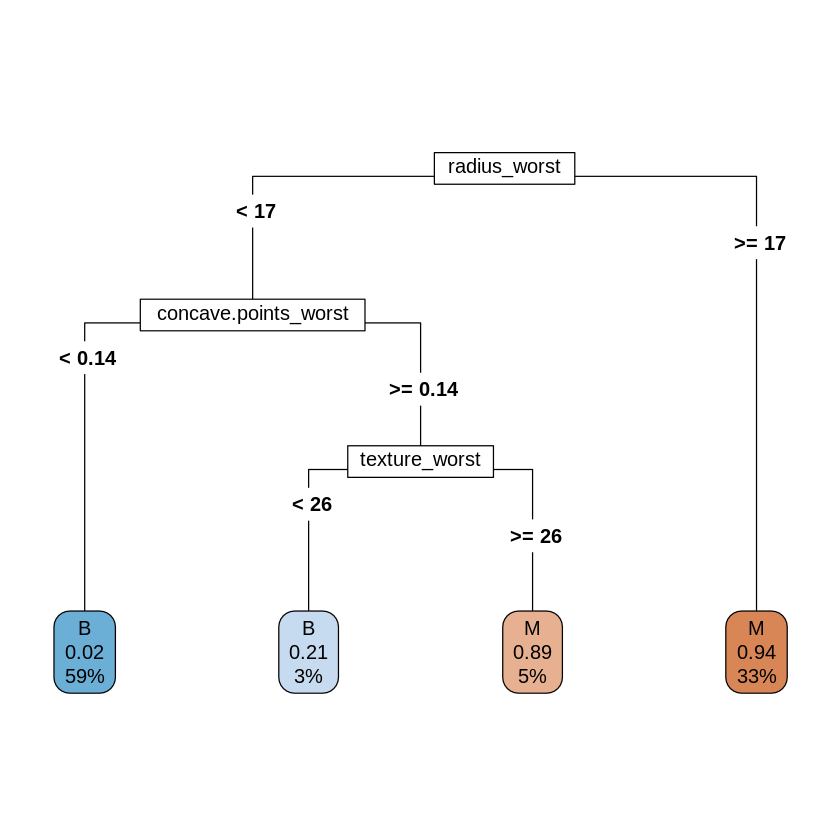

In [ ]:
# Providing the visualization
#install.packages("rpart.plot")
library("rpart.plot")

# Getting the decision tree model
tree_info <- getLearnerModel(dt_model)

# Plotting the DT model
rpart.plot(tree_info, roundint = FALSE, box.palette = "BuBn", type = 5)

## $\color{purple}{\text{c)}}$

In [ ]:
# Providing model performance metrics
cat("Accuracy and misclassification rate for DT\n", performance(dt_pred, measures = list(acc, mmce)))
cat("\nAccuracy and misclassification rate for NB\n", performance(nb_pred, measures = list(acc, mmce)))
cat("\nAccuracy and misclassification rate for LR\n", performance(lr_pred, measures = list(acc, mmce)))
cat("\nAccuracy and misclassification rate for LDA\n", performance(lda_pred, measures = list(acc, mmce)))

Accuracy and misclassification rate for DT
 0.9595782 0.04042179
Accuracy and misclassification rate for NB
 0.9367311 0.06326889
Accuracy and misclassification rate for LR
 1 0
Accuracy and misclassification rate for LDA
 0.9648506 0.03514938

## $\color{purple}{\text{d)}}$

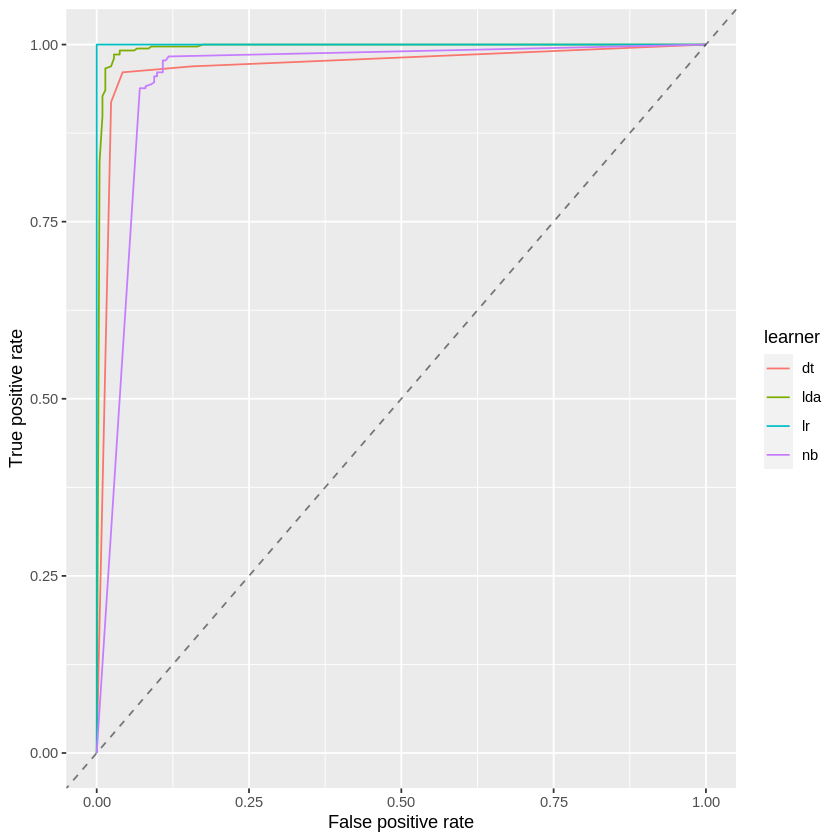

In [ ]:
# Generating data to get ROC curve
df = generateThreshVsPerfData(list(dt = dt_pred, nb = nb_pred, lda = lda_pred, lr = lr_pred), measure = list(fpr, tpr))

# ROC curve
plotROCCurves(df)

In [ ]:
# Compute AUC
cat("AUC for DT\n", performance(dt_pred, measures = auc))
cat("\nAUC for NB\n", performance(nb_pred, measures = auc))
cat("\nAUC for LR\n", performance(lr_pred, measures = auc))
cat("\nAUC for LDA\n", performance(lda_pred, measures = auc))

AUC for DT
 0.9691414
AUC for NB
 0.988518
AUC for LR
 1
AUC for LDA
 0.996525

## $\color{purple}{\text{e)}}$

Of the models, the Logistic Regression model performs the highest. This is apparent in the ROC curve because it is the highest line. The area under the ROC curve for Logistic Regression is 1, suggesting that the model perfectly predicts whether a tumor is benign or malignant. It correspondingly has an accuracy rate of 1 and a misclassification rate of 0.